## Using the Biosynthetic Cluster Simulator (BCS) module with stereospecific SMARTS operators for forward synthesis prediction tasks
### December 11, 2025

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import bcs
from retrotide import  structureDB
from collections import OrderedDict
from itertools import product
import matplotlib.pyplot as plt

[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.
[11:00:09] product atom-mapping number 10 not found in reactants.


















































































































































































































































































































































































































































































































































































































































































































































["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substrate': 'isobutmal'}", "KR{'type': 'A2'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B2'}", 'loading: False']
["AT{'substrate': 'allylmal'}", "KR{'type': 'A2'}",

### Here, we will go through examples of creating a bimodular type I PKS with different reductive loop architectures and demonstrate their possible 3D triketide products

#### Example 1: Reductive Loop M1 - KR and Reductive Loop M2 - KR

Let's start with using the bcs module to construct a bimodular PKS where each module accepts methylmalonyl-CoA. When adding a reductive loop domain, you must specify the type. The subtypes of each reductive loop domain regulates the absolute stereochemistry present in the resulting PKS product. Note that RDKit assigns stereochemistry labels based on Cahn-Ingold-Prelog rules. PKS KR subtypes map to specific local R/S configurations but may manifest as a different absolute configuration when the molecule is viewed in its entirety.

CC[C@H](O)[C@@H](C)[C@H](O)[C@@H](C)C(=O)[S]


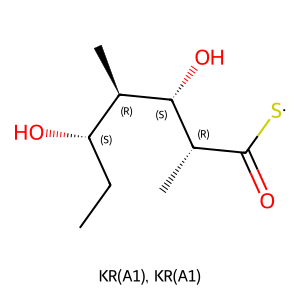

In [2]:
def build_kr_kr_pks(subtype1: str, subtype2: str) -> Chem.Mol:
    AT_loading = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    loading_domains_dict = OrderedDict({bcs.AT: AT_loading})
    loading = bcs.Module(domains = loading_domains_dict, loading = True)

    AT_mod_1 = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    KR_mod_1 = bcs.KR(active = True, type = subtype1)
    module1_domains_dict = OrderedDict({bcs.AT: AT_mod_1, bcs.KR: KR_mod_1})
    module1 = bcs.Module(domains = module1_domains_dict, loading = False)

    AT_mod_2 = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    KR_mod_2 = bcs.KR(active = True, type = subtype2)
    module2_domains_dict = OrderedDict({bcs.AT: AT_mod_2, bcs.KR: KR_mod_2})
    module2 = bcs.Module(domains = module2_domains_dict, loading = False)

    cluster = bcs.Cluster(modules=[loading, module1, module2])
    mol = cluster.computeProduct(structureDB)
    return mol

# Let's build a bimodular PKS with two A1-type KRs
mol =build_kr_kr_pks('A1', 'A1')
print(Chem.MolToSmiles(mol))

# Let's add stereochemistry labels to the PKS product to reflect the absolute stereochemistry that results from each KR domain.
def add_rs_labels(mol: Chem.Mol, subtype1: str, subtype2: str):
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    for atom in mol.GetAtoms():
        chiral_centers = dict(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        atom_idx = atom.GetIdx()
        if atom_idx in chiral_centers:
            label = f'({chiral_centers[atom_idx]})'
            atom.SetProp('atomNote', label)
        img = Draw.MolToImage(mol, legend=f'KR({subtype1}), KR({subtype2})')
    return img

img = add_rs_labels(mol, 'A1', 'A1')
img.show()

Overall, there are 8 KR subtypes defined in the BCS module.
- A1, A2, B1, and B2: Corresponds to different alpha-substituent and beta-hydroxyl stereochemistry
- C1: Performs niether reduction or epimerization
- C2: Performs epimerization without reduction

When the substrate does not have an alpha substituent (i.e. Malonyl-CoA)
- A and B: Corresponds to different beta-hydroxyl stereochemistry

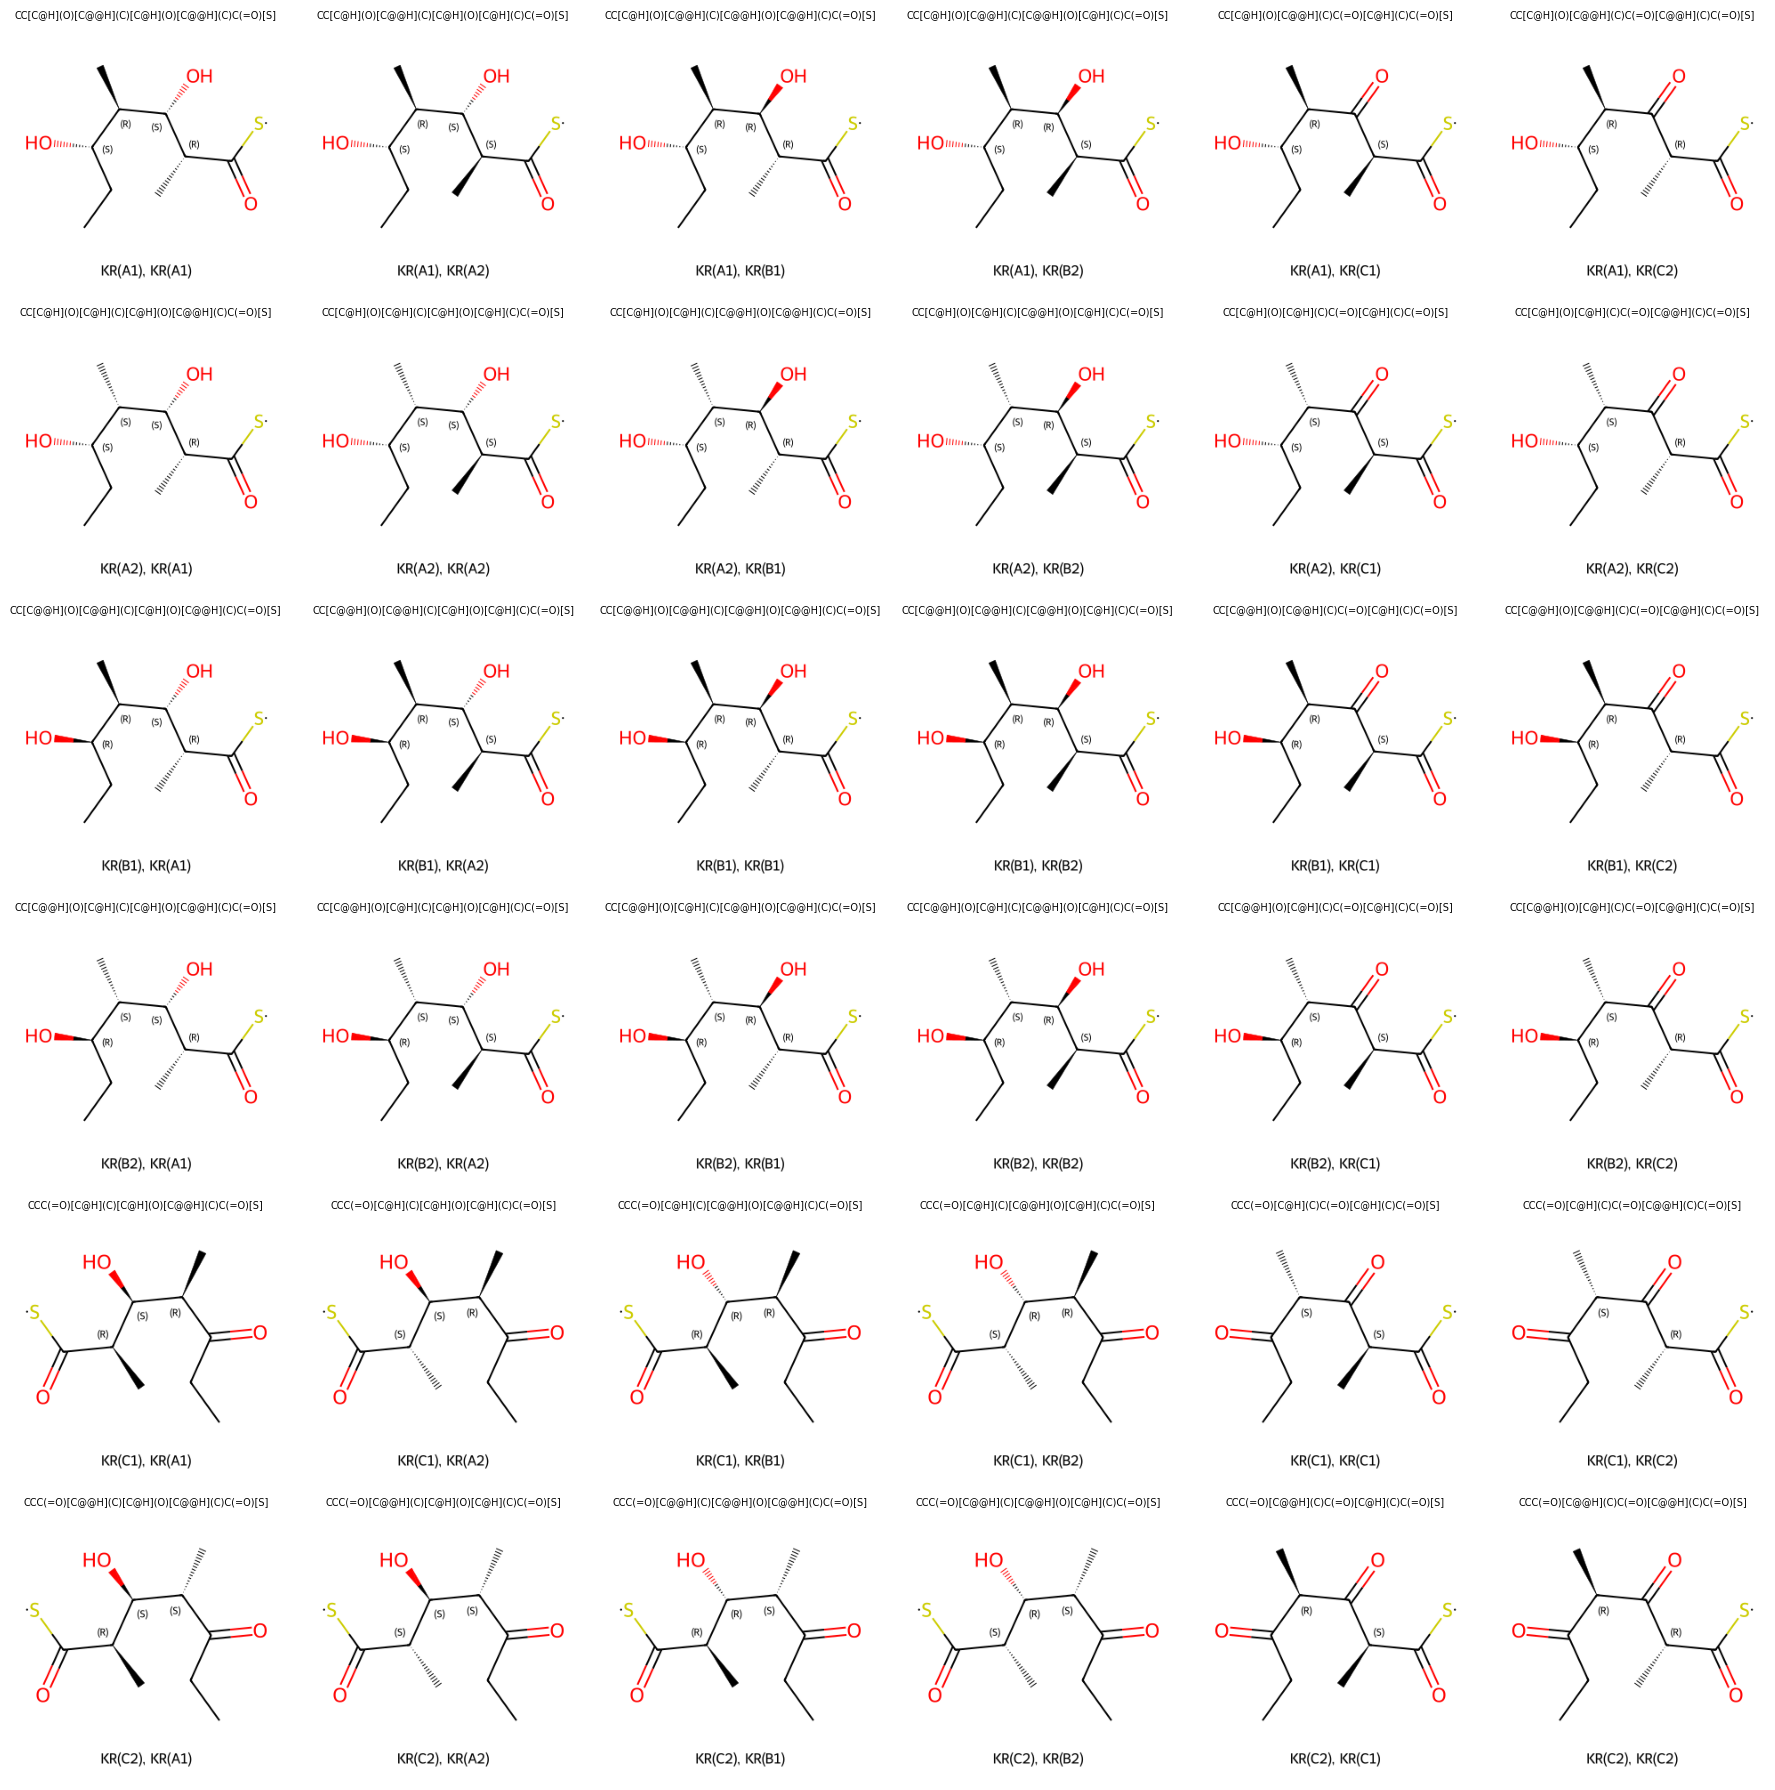

In [3]:
# Lets visualize the 3D triketide PKS products for each combination of these KR subtypes
subtypes = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
mol_smis = []
mol_imgs = []

for subtype1, subtype2 in product(subtypes, repeat=2):
    mol = build_kr_kr_pks(subtype1, subtype2)
    mol_imgs.append(add_rs_labels(mol, subtype1, subtype2))
    mol_smis.append(Chem.MolToSmiles(mol))

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18,18))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
img_idx = 0
for i in range(6):
    for j in range(6):
        axes[i, j]
        axes[i, j].imshow(mol_imgs[img_idx], cmap='gray')
        axes[i, j].set_title(f'{mol_smis[img_idx]}', fontsize=7)
        axes[i, j].axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()

#### Example 2: Reductive Loop M1 - KR and Reductive Loop M2 - DH-KR

DH-KR reductive loops control the polyketide backbone alkene stereochemistry. Overall, there are two DH subtypes defined in the BCS module.

The DH subtype is specific to the beta-hydroxyl stereochemistry set by the KR domain. Thus, the DH-KR subtypes are defined with respect to one another.

For PKS modules that accept malonyl-CoA:
- DH(Z)-KR(A) and DH(E)-KR(B) result in Z and E alkenes, respectively.

If the substrate has an alpha-substituent:
- Only DH(E)-KR(B) is possible.

CC[C@H](O)[C@@H](C)/C=C\C(=O)[S]


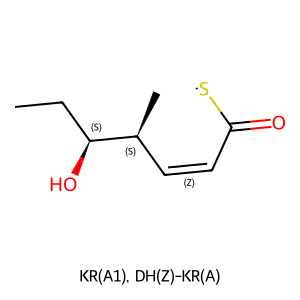

In [4]:
def build_kr_dh_kr_pks(subtype1: str, subtype2_dh: str, subtype2_kr: str) -> Chem.Mol:
    AT_loading = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    loading_domains_dict = OrderedDict({bcs.AT: AT_loading})
    loading = bcs.Module(domains = loading_domains_dict, loading = True)

    AT_mod_1 = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    KR_mod_1 = bcs.KR(active = True, type = subtype1)
    module1_domains_dict = OrderedDict({bcs.AT: AT_mod_1, bcs.KR: KR_mod_1})
    module1 = bcs.Module(domains = module1_domains_dict, loading = False)

    AT_mod_2 = bcs.AT(active = True, substrate = 'Malonyl-CoA')
    KR_mod_2 = bcs.KR(active = True, type = subtype2_kr)
    DH_mod_2 = bcs.DH(active = True, type = subtype2_dh)
    module2_domains_dict = OrderedDict({bcs.AT: AT_mod_2, bcs.KR: KR_mod_2, bcs.DH: DH_mod_2})
    module2 = bcs.Module(domains = module2_domains_dict, loading = False)

    cluster = bcs.Cluster(modules=[loading, module1, module2])
    mol = cluster.computeProduct(structureDB)
    return mol

# Let's build a bimodular PKS with an A1-type KR in the first extension module
# and a Z-type DH and A-type KR in the second extension module
mol = build_kr_dh_kr_pks('A1', 'Z', 'A')
print(Chem.MolToSmiles(mol))

# Let's add stereochemistry labels to the PKS product to reflect the absolute stereochemistry set by each reductive loop domain.
def add_rs_ez_labels(mol: Chem.Mol, subtype1: str, subtype2_dh: str, subtype2_kr: str):
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    for atom in mol.GetAtoms():
        chiral_centers = dict(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        atom_idx = atom.GetIdx()
        if atom_idx in chiral_centers:
            label = f'({chiral_centers[atom_idx]})'
            atom.SetProp('atomNote', label)
        for bond in mol.GetBonds():
            if bond.GetBondType() == Chem.BondType.DOUBLE:
                stereo = bond.GetStereo()
                if stereo == Chem.BondStereo.STEREOZ:
                    bond.SetProp('bondNote', '(Z)')
                elif stereo == Chem.BondStereo.STEREOE:
                    bond.SetProp('bondNote', '(E)')
        img = Draw.MolToImage(mol, legend=f'KR({subtype1}), DH({subtype2_dh})-KR({subtype2_kr})')
    return img

img = add_rs_ez_labels(mol, 'A1', 'Z', 'A')
img.show()

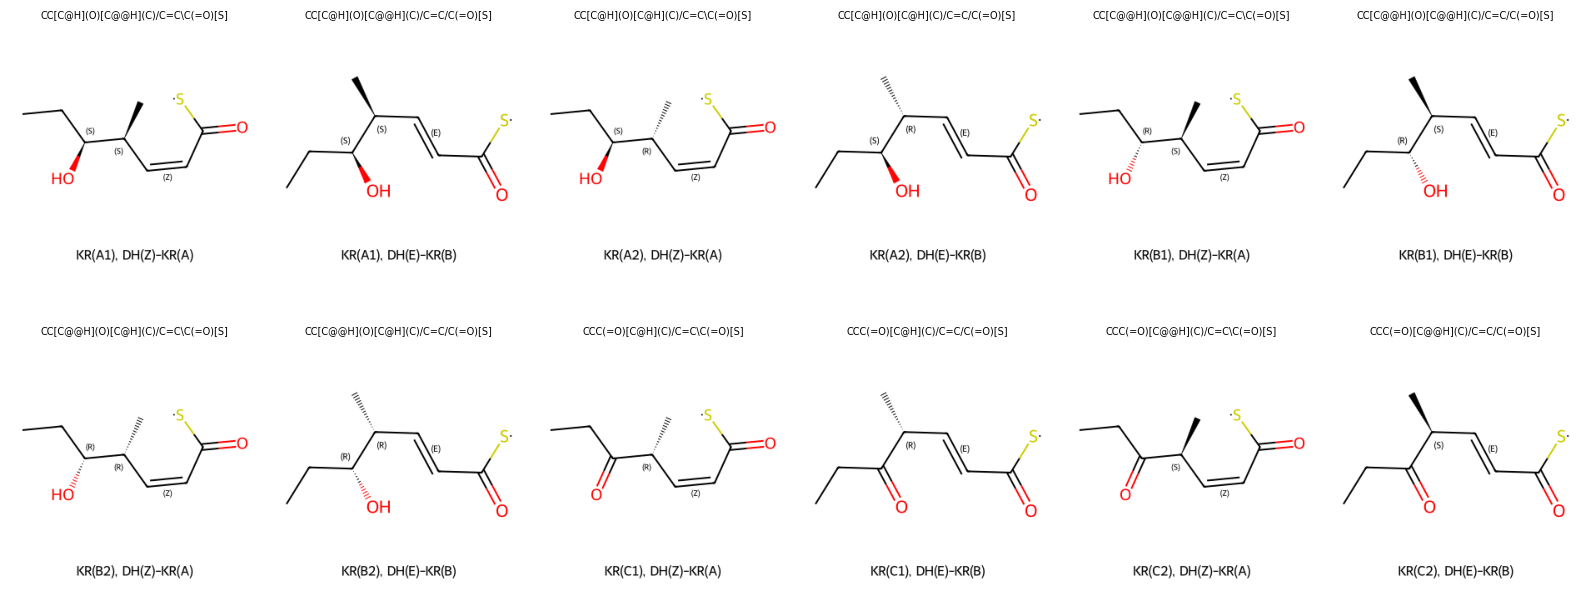

In [5]:
# Lets visualize the 3D triketide products for each combination of these reductive loop subtypes
subtypes_M1 = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
subtypes_M2 = [('Z', 'A'), ('E', 'B')]
mol_smis = []
mol_imgs = []

for subtype1, subtype2 in product(subtypes_M1, subtypes_M2):
    mol = build_kr_dh_kr_pks(subtype1, subtype2[0], subtype2[1])
    mol_imgs.append(add_rs_ez_labels(mol, subtype1, subtype2[0], subtype2[1]))
    mol_smis.append(Chem.MolToSmiles(mol))

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,7))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
img_idx = 0
for i in range(2):
    for j in range(6):
        axes[i, j]
        axes[i, j].imshow(mol_imgs[img_idx], cmap='gray')
        axes[i, j].set_title(f'{mol_smis[img_idx]}', fontsize=7)
        axes[i, j].axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()

#### Example 3: Reductive Loop M1 - KR and Reductive Loop M2 - DH-ER-KR

Here, module 2 has a fully reducing RL architecture - DH-ER-KR - resulting in an alkane. Overall, there are two ER subtypes defined in the BCS module.

The ER domain resets the stereochemistry of the alpha chiral center.
- L, D: Corresponds to different alpha substituent stereochemistry

The ER domain can only reduce E alkenes. Thus, the DH and KR domains of a DH-ER-KR reductive loop must be types E and B1, respectively.

If there is no alpha substituent, the ER subtype is arbitrary and the DH and KR domains of a DH-ER-KR reductive loop must be types E and B, respectively.

CC[C@H](O)[C@@H](C)C[C@H](C)C(=O)[S]


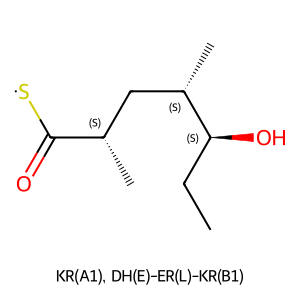

In [6]:
def build_kr_dh_er_kr_pks(subtype1: str, subtype2_er: str) -> Chem.Mol:
    AT_loading = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    loading_domains_dict = OrderedDict({bcs.AT: AT_loading})
    loading = bcs.Module(domains = loading_domains_dict, loading = True)

    AT_mod_1 = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    KR_mod_1 = bcs.KR(active = True, type = subtype1)
    module1_domains_dict = OrderedDict({bcs.AT: AT_mod_1, bcs.KR: KR_mod_1})
    module1 = bcs.Module(domains = module1_domains_dict, loading = False)

    AT_mod_2 = bcs.AT(active = True, substrate = 'Methylmalonyl-CoA')
    KR_mod_2 = bcs.KR(active = True, type = 'B1')
    DH_mod_2 = bcs.DH(active = True, type = 'E')
    ER_mod_2 = bcs.ER(active = True, type = subtype2_er)
    module2_domains_dict = OrderedDict({bcs.AT: AT_mod_2, bcs.KR: KR_mod_2, bcs.DH: DH_mod_2, bcs.ER: ER_mod_2})
    module2 = bcs.Module(domains = module2_domains_dict, loading = False)

    cluster = bcs.Cluster(modules=[loading, module1, module2])
    mol = cluster.computeProduct(structureDB)
    return mol

mol = build_kr_dh_er_kr_pks('A1', 'L')
print(Chem.MolToSmiles(mol))

def add_rs_ez_labels(mol: Chem.Mol, subtype1: str, subtype2_er: str):
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    for atom in mol.GetAtoms():
        chiral_centers = dict(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        atom_idx = atom.GetIdx()
        if atom_idx in chiral_centers:
            label = f'({chiral_centers[atom_idx]})'
            atom.SetProp('atomNote', label)
        for bond in mol.GetBonds():
            if bond.GetBondType() == Chem.BondType.DOUBLE:
                stereo = bond.GetStereo()
                if stereo == Chem.BondStereo.STEREOZ:
                    bond.SetProp('bondNote', '(Z)')
                elif stereo == Chem.BondStereo.STEREOE:
                    bond.SetProp('bondNote', '(E)')
        img = Draw.MolToImage(mol, legend=f'KR({subtype1}), DH(E)-ER({subtype2_er})-KR(B1)')
    return img

img = add_rs_ez_labels(mol, 'A1', 'L')
img.show()

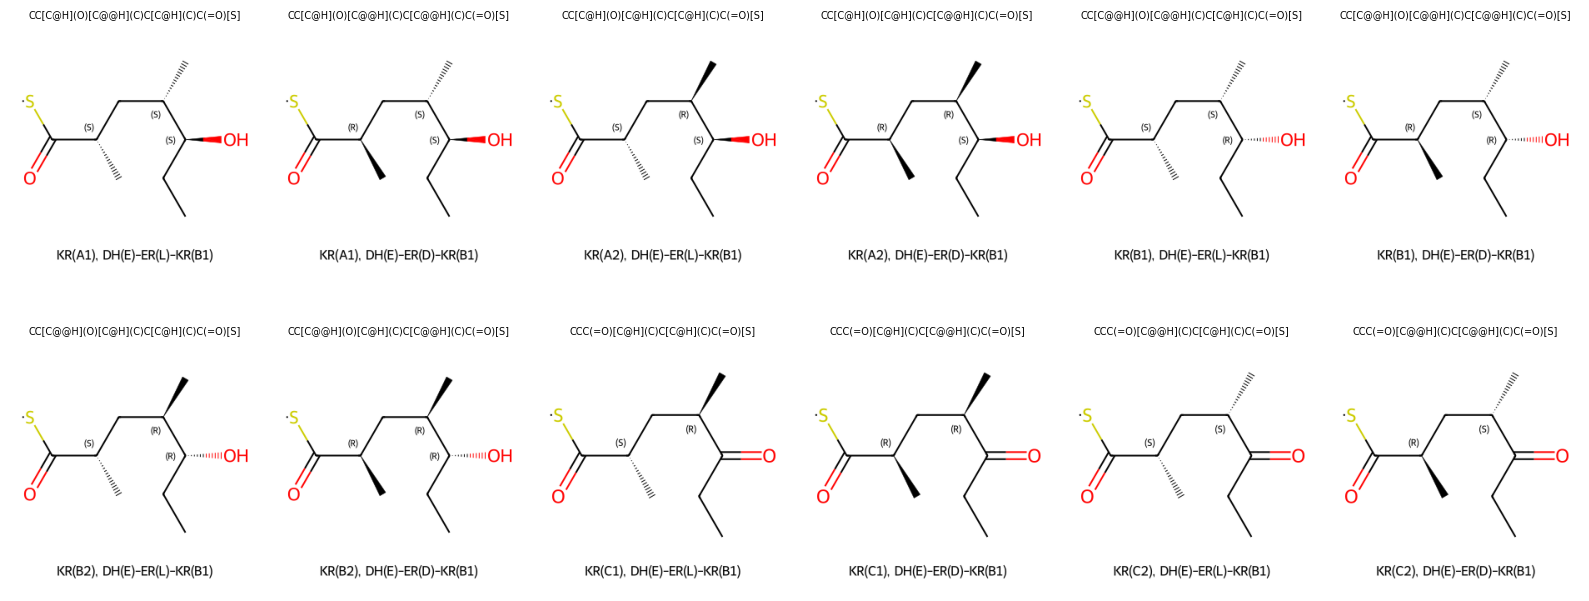

In [7]:
# Lets visualize the 3D triketide products for each combination of these reductive loop subtypes
subtypes_M1 = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
subtypes_M2 = [('E', 'L', 'B1'), ('E', 'D', 'B1')]
mol_smis = []
mol_imgs = []

for subtype1, subtype2 in product(subtypes_M1, subtypes_M2):
    mol = build_kr_dh_er_kr_pks(subtype1, subtype2[1])
    mol_imgs.append(add_rs_ez_labels(mol, subtype1, subtype2[1]))
    mol_smis.append(Chem.MolToSmiles(mol))

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,7))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
img_idx = 0
for i in range(2):
    for j in range(6):
        axes[i, j]
        axes[i, j].imshow(mol_imgs[img_idx], cmap='gray')
        axes[i, j].set_title(f'{mol_smis[img_idx]}', fontsize=7)
        axes[i, j].axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()